# Data Preprocessing

This notebook will load the [BANES](https://data.bathhacked.org/datasets/banes-energy-data-electricity) dataset and perform the following preprocessing steps:

- Explore the data
- Interpolate the negative values.

The [Solcast](https://toolkit.solcast.com.au/historical/timeseries/request) dataset will also be merged with the BANES dataset.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12.8, 7.2)

Load the dataset.

In [2]:
df = pd.read_csv('../data/BANES.csv')
df.head()

,id,date,location,postcode,units,totalunits,_00_30,_01_00,_01_30,_02_00,...,_20_30,_21_00,_21_30,_22_00,_22_30,_23_00,_23_30,_24_00,mpan,msid
0,19cb9c7d28276d8334660763dc12c825,2018-01-08T00:00:00+00:00,The Hollies Offices MSN (P272 HH),BA3 2DP,kWh,519.100000,7.800,7.600,7.500,7.700,...,7.900,7.500,7.500,7.200,6.700,6.200,6.700,6.600,2.200030e+12,E10BG07339
1,ab52de560fc2b426a22456e1924b8d99,2018-08-16T00:00:00+00:00,The Hollies Offices MSN Car Park Barrier,BA3 2DP,kWh,7.244000,0.368,0.371,0.371,0.372,...,0.103,0.369,0.373,0.371,0.366,0.375,0.374,0.367,2.200042e+12,E11BG49253
2,b7886b1cc32975a59e92565a203893bf,2018-10-25T00:00:00+00:00,The Hollies Offices MSN Car Park Barrier,BA3 2DP,kWh,10.283000,0.364,0.370,0.371,0.372,...,0.373,0.369,0.375,0.374,0.368,0.373,0.374,0.375,2.200042e+12,E11BG49253
3,b84bdfdd746e271273ac0f8e03338ca8,2014-02-23T00:00:00+00:00,The Hollies Offices MSN (P272 HH),BA3 2DP,kWh,282.930000,5.420,5.390,5.430,5.340,...,6.790,6.610,5.960,5.390,6.590,5.480,5.500,5.210,2.200030e+12,E10BG07339
4,0f4fcc016c4edbe43b693d60b575b81d,2012-03-08T00:00:00+00:00,The Hollies Offices MSN Car Park Barrier,BA3 2DP,kWh,9.492001,0.365,0.372,0.375,0.377,...,0.370,0.364,0.367,0.372,0.368,0.367,0.373,0.366,2.200042e+12,E11BG49253


**First Question**: The column `units` contains the units of the data. Are there any other units?

In [5]:
df['units'].unique()

array(['kWh'], dtype=object)

No the data is always in kWh.

**Second Question**: What is this column `id`?

In [3]:
df['id'].nunique(), df.shape[0]

(166259, 166276)

In [4]:
df['id'].nunique(), df.drop_duplicates().shape[0]

(166259, 166273)

In [24]:
duplicate_ids = df[df.duplicated(subset='id')]['id']
duplicate_ids = df[df['id'].isin(duplicate_ids)]
duplicate_ids.head()

,id,date,location,postcode,totalunits,_00_30,_01_00,_01_30,_02_00,_02_30,...,_20_30,_21_00,_21_30,_22_00,_22_30,_23_00,_23_30,_24_00,mpan,msid
33853,70195b5a6b49362795a1a06e0fc60478,2019-11-12T00:00:00+00:00,Mechanical Control Panel 2,BS31 1FS,16.29688,0.296875,0.300781,0.300781,0.300781,0.300781,...,0.300781,0.300781,0.296875,0.301563,0.300000,0.300781,0.300781,0.296875,NaN,NaN
33861,12f1a32b7ea69a9ac36ff90e97323d1f,2019-11-12T00:00:00+00:00,Ground Floor South - Power & Lighting,BS31 1FS,37.29688,0.296875,0.296875,0.304688,0.296875,0.304688,...,0.296875,0.304688,0.296875,0.300000,0.301563,0.296875,0.304688,0.296875,NaN,NaN
33867,5d1540cb80e39ba6eb99a97b844cf4db,2019-11-12T00:00:00+00:00,Ground Floor South - Power,BS31 1FS,19.89844,0.199219,0.300781,0.199219,0.300781,0.199219,...,0.203125,0.296875,0.203125,0.298438,0.201563,0.296875,0.203125,0.296875,NaN,NaN
33892,98710a3cebbae7a5c83d35149a2938b0,2019-11-12T00:00:00+00:00,Ground Floor South - Lighting,BS31 1FS,18.30078,0.101562,0.000000,0.097656,0.101562,0.101562,...,0.101562,0.000000,0.101562,0.098437,0.100781,0.000000,0.097656,0.101562,NaN,NaN
33895,228f63c9b178a0d6fb66e9b3972a5e4f,2019-11-12T00:00:00+00:00,Ground & First Floor North - Power & Lighting,BS31 1FS,59.20313,0.500000,0.601562,0.500000,0.601562,0.500000,...,0.601562,0.601562,0.601562,0.596875,0.496875,0.601562,0.601562,0.500000,NaN,NaN


In [25]:
duplicate_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 33853 to 45266
Data columns (total 55 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          34 non-null     object 
 1   date        34 non-null     object 
 2   location    34 non-null     object 
 3   postcode    34 non-null     object 
 4   totalunits  34 non-null     float64
 5   _00_30      34 non-null     float64
 6   _01_00      34 non-null     float64
 7   _01_30      34 non-null     float64
 8   _02_00      34 non-null     float64
 9   _02_30      34 non-null     float64
 10  _03_00      34 non-null     float64
 11  _03_30      34 non-null     float64
 12  _04_00      34 non-null     float64
 13  _04_30      34 non-null     float64
 14  _05_00      34 non-null     float64
 15  _05_30      34 non-null     float64
 16  _06_00      34 non-null     float64
 17  _06_30      34 non-null     float64
 18  _07_00      34 non-null     float64
 19  _07_30      34 non-null 

In [26]:
duplicate_ids.shape

(34, 55)

In [27]:
duplicate_ids.sort_values(by='id').head()

,id,date,location,postcode,totalunits,_00_30,_01_00,_01_30,_02_00,_02_30,...,_20_30,_21_00,_21_30,_22_00,_22_30,_23_00,_23_30,_24_00,mpan,msid
36949,0623e9622265b1346d5b4fd74b63ae0d,2019-11-12T00:00:00+00:00,Mechanical Control Panel 1,BS31 1FS,2.869922e+01,0.398438,0.402344,0.398438,0.500000,0.402344,...,0.296875,0.402344,0.398438,0.402344,0.398438,0.398438,0.402344,0.398438,NaN,NaN
33991,0623e9622265b1346d5b4fd74b63ae0d,2019-11-12T00:00:00+00:00,Mechanical Control Panel 1,BS31 1FS,2.869922e+01,0.398438,0.402344,0.398438,0.500000,0.402344,...,0.296875,0.402344,0.398438,0.400781,0.400000,0.398438,0.402344,0.398438,NaN,NaN
39020,08e7a4f3d3117a79ac0dd065964d9aec,2019-10-22T00:00:00+00:00,Air cooled chiller 1,BS31 1FS,-6.728121e+07,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
36508,08e7a4f3d3117a79ac0dd065964d9aec,2019-10-22T00:00:00+00:00,Air cooled chiller 1,BS31 1FS,-6.728121e+07,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
33861,12f1a32b7ea69a9ac36ff90e97323d1f,2019-11-12T00:00:00+00:00,Ground Floor South - Power & Lighting,BS31 1FS,3.729688e+01,0.296875,0.296875,0.304688,0.296875,0.304688,...,0.296875,0.304688,0.296875,0.300000,0.301563,0.296875,0.304688,0.296875,NaN,NaN


The `id` is a unique value in every row. The exception happens in duplicate values, therefore it is an unnecessary column.

`mpan` and `msid` are smart-meters identifiers, therefore they are not necessary. `totalunits` also seems to be unnecessary.

In [3]:
df['date'] = pd.to_datetime(df['date'])
df.drop(['totalunits', 'id', 'mpan', 'msid'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166276 entries, 0 to 166275
Data columns (total 51 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   date      166276 non-null  datetime64[ns, UTC]
 1   location  166276 non-null  object             
 2   postcode  166276 non-null  object             
 3   _00_30    166276 non-null  float64            
 4   _01_00    166276 non-null  float64            
 5   _01_30    166276 non-null  float64            
 6   _02_00    166276 non-null  float64            
 7   _02_30    166276 non-null  float64            
 8   _03_00    166276 non-null  float64            
 9   _03_30    166276 non-null  float64            
 10  _04_00    166276 non-null  float64            
 11  _04_30    166276 non-null  float64            
 12  _05_00    166276 non-null  float64            
 13  _05_30    166276 non-null  float64            
 14  _06_00    166276 non-null  float64            
 15  

#### Data changes

Group by date and location, dropping the duplicates. Some duplicates actually have small differences, most likely because of precision points.

In [4]:
df = df.groupby(['date', 'location']).mean().reset_index()
df.describe()

,_00_30,_01_00,_01_30,_02_00,_02_30,_03_00,_03_30,_04_00,_04_30,_05_00,...,_19_30,_20_00,_20_30,_21_00,_21_30,_22_00,_22_30,_23_00,_23_30,_24_00
count,161850.000000,161850.000000,161850.000000,161850.000000,161850.000000,161850.000000,161850.000000,161850.000000,161850.000000,161850.000000,...,161850.000000,161850.000000,161850.000000,161850.000000,161850.000000,161850.000000,161850.000000,161850.000000,161850.000000,161850.000000
mean,2.594987,2.700851,2.864420,2.862905,2.854627,2.837580,2.885198,2.888271,2.939241,3.011712,...,2.958676,2.896791,2.808626,2.733417,2.601196,2.545218,2.541027,2.525626,2.559059,2.579171
std,5.526311,5.591934,5.678124,5.671403,5.658014,5.628027,5.647936,5.650924,5.780458,5.978732,...,6.638680,6.372483,6.181494,5.998420,5.811340,5.677383,5.680527,5.594824,5.611156,5.577061
min,0.000000,0.000000,0.000000,0.000000,-0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.000012,-0.000781,0.000000,0.000000,-0.000012,0.000000,0.000000,0.000000,0.000000
25%,0.192000,0.193000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.199000,0.194000,...,0.196000,0.202000,0.204000,0.213000,0.214000,0.212000,0.207000,0.204000,0.204000,0.197000
50%,0.547000,0.560000,0.587000,0.586000,0.586000,0.585000,0.591000,0.590000,0.586000,0.574000,...,0.531000,0.537000,0.536000,0.540000,0.542000,0.540000,0.538000,0.539000,0.542000,0.545000
75%,1.792000,1.896000,2.100000,2.100000,2.100000,2.100000,2.229000,2.249000,2.253750,2.299000,...,1.800000,1.875000,1.800000,1.786000,1.638750,1.640000,1.636000,1.665000,1.672000,1.718750
max,43.500000,46.500000,45.000000,42.600000,42.100000,42.300000,42.500000,40.300000,43.300000,43.300000,...,53.500000,52.100000,49.900000,48.400000,48.000000,47.300000,47.000000,47.500000,44.800000,45.000000


One of the columns is the `date` which is the day of the data, while the columns `_00_30` to `_24_00` are the energy values for each hour of the day.

In this step we will drop this columns and join them with the date, so they will be extended vertically instead of horizontally, like they are now.

In [5]:
df = pd.melt(df, id_vars=['location', 'date'], value_vars=df.columns[1:], var_name='timestamp', value_name='energy')
df.head()

,location,date,timestamp,energy
0,Bath Central Library Electricity (HH),2006-10-01 00:00:00+00:00,_00_30,5.9
1,Guildhall Electricity Supply 1 (HH),2006-10-01 00:00:00+00:00,_00_30,32.8
2,Bath Central Library Electricity (HH),2006-10-02 00:00:00+00:00,_00_30,6.0
3,Guildhall Electricity Supply 1 (HH),2006-10-02 00:00:00+00:00,_00_30,30.5
4,Bath Central Library Electricity (HH),2006-10-03 00:00:00+00:00,_00_30,6.0


In [6]:
df['timestamp'] = df['timestamp'].apply(lambda x: x[1:].replace('_', ':'))
df.head()

,location,date,timestamp,energy
0,Bath Central Library Electricity (HH),2006-10-01 00:00:00+00:00,00:30,5.9
1,Guildhall Electricity Supply 1 (HH),2006-10-01 00:00:00+00:00,00:30,32.8
2,Bath Central Library Electricity (HH),2006-10-02 00:00:00+00:00,00:30,6.0
3,Guildhall Electricity Supply 1 (HH),2006-10-02 00:00:00+00:00,00:30,30.5
4,Bath Central Library Electricity (HH),2006-10-03 00:00:00+00:00,00:30,6.0


In [7]:
df.rename(columns={'timestamp': 'timedelta'}, inplace=True)

In [8]:
df['timedelta'] = df['timedelta'].apply(lambda x: x + ":00")
df.head()

,location,date,timedelta,energy
0,Bath Central Library Electricity (HH),2006-10-01 00:00:00+00:00,00:30:00,5.9
1,Guildhall Electricity Supply 1 (HH),2006-10-01 00:00:00+00:00,00:30:00,32.8
2,Bath Central Library Electricity (HH),2006-10-02 00:00:00+00:00,00:30:00,6.0
3,Guildhall Electricity Supply 1 (HH),2006-10-02 00:00:00+00:00,00:30:00,30.5
4,Bath Central Library Electricity (HH),2006-10-03 00:00:00+00:00,00:30:00,6.0


In [9]:
df['timedelta'] = pd.to_timedelta(df['timedelta'])

In [10]:
df.head()

,location,date,timedelta,energy
0,Bath Central Library Electricity (HH),2006-10-01 00:00:00+00:00,0 days 00:30:00,5.9
1,Guildhall Electricity Supply 1 (HH),2006-10-01 00:00:00+00:00,0 days 00:30:00,32.8
2,Bath Central Library Electricity (HH),2006-10-02 00:00:00+00:00,0 days 00:30:00,6.0
3,Guildhall Electricity Supply 1 (HH),2006-10-02 00:00:00+00:00,0 days 00:30:00,30.5
4,Bath Central Library Electricity (HH),2006-10-03 00:00:00+00:00,0 days 00:30:00,6.0


In [11]:
df['time'] = df['date'] + df['timedelta']
df.head()

,location,date,timedelta,energy,time
0,Bath Central Library Electricity (HH),2006-10-01 00:00:00+00:00,0 days 00:30:00,5.9,2006-10-01 00:30:00+00:00
1,Guildhall Electricity Supply 1 (HH),2006-10-01 00:00:00+00:00,0 days 00:30:00,32.8,2006-10-01 00:30:00+00:00
2,Bath Central Library Electricity (HH),2006-10-02 00:00:00+00:00,0 days 00:30:00,6.0,2006-10-02 00:30:00+00:00
3,Guildhall Electricity Supply 1 (HH),2006-10-02 00:00:00+00:00,0 days 00:30:00,30.5,2006-10-02 00:30:00+00:00
4,Bath Central Library Electricity (HH),2006-10-03 00:00:00+00:00,0 days 00:30:00,6.0,2006-10-03 00:30:00+00:00


In [12]:
df.drop(['timedelta', 'date'], axis=1, inplace=True)
df.head()

,location,energy,time
0,Bath Central Library Electricity (HH),5.9,2006-10-01 00:30:00+00:00
1,Guildhall Electricity Supply 1 (HH),32.8,2006-10-01 00:30:00+00:00
2,Bath Central Library Electricity (HH),6.0,2006-10-02 00:30:00+00:00
3,Guildhall Electricity Supply 1 (HH),30.5,2006-10-02 00:30:00+00:00
4,Bath Central Library Electricity (HH),6.0,2006-10-03 00:30:00+00:00


In [13]:
df.groupby(['location', 'time']).sum().reset_index().head()

,location,time,energy
0,## OLD Paulton Library Electricity Supply 1,2008-06-14 00:30:00+00:00,0.08
1,## OLD Paulton Library Electricity Supply 1,2008-06-14 01:00:00+00:00,0.07
2,## OLD Paulton Library Electricity Supply 1,2008-06-14 01:30:00+00:00,0.08
3,## OLD Paulton Library Electricity Supply 1,2008-06-14 02:00:00+00:00,0.07
4,## OLD Paulton Library Electricity Supply 1,2008-06-14 02:30:00+00:00,0.08


We have the data with everything we need, so we can start the analysis.

## Merge with Solcast

In [14]:
df.describe()

,energy
count,7.768800e+06
mean,-7.766085e+00
std,2.569213e+04
min,-6.728121e+07
25%,2.200000e-01
50%,7.500000e-01
75%,3.240000e+00
max,7.470000e+01


In [15]:
solcast = pd.read_csv('../data/Solcast_PT30M.csv', parse_dates=['PeriodEnd', 'PeriodStart'])
solcast.head()

,PeriodEnd,PeriodStart,Period,AirTemp,CloudOpacity,Dni,PrecipitableWater,RelativeHumidity,WindDirection10m,WindSpeed10m
0,2007-01-01 01:00:00+00:00,2007-01-01 00:30:00+00:00,PT30M,8.0,0.0,0,11.6,81.4,249,9.9
1,2007-01-01 01:30:00+00:00,2007-01-01 01:00:00+00:00,PT30M,7.7,0.0,0,11.3,83.3,251,9.7
2,2007-01-01 02:00:00+00:00,2007-01-01 01:30:00+00:00,PT30M,7.3,0.0,0,11.1,85.2,253,9.5
3,2007-01-01 02:30:00+00:00,2007-01-01 02:00:00+00:00,PT30M,7.0,0.0,0,10.9,87.2,255,9.4
4,2007-01-01 03:00:00+00:00,2007-01-01 02:30:00+00:00,PT30M,6.6,0.0,0,10.7,89.2,256,9.2


In [16]:
solcast = solcast[['PeriodStart', 'AirTemp', 'RelativeHumidity', 'Dni']]
solcast.rename(columns={'PeriodStart': 'time'}, inplace=True)
df = pd.merge(df, solcast, on='time', how='left')
df.head()

,location,energy,time,AirTemp,RelativeHumidity,Dni
0,Bath Central Library Electricity (HH),5.9,2006-10-01 00:30:00+00:00,NaN,NaN,NaN
1,Guildhall Electricity Supply 1 (HH),32.8,2006-10-01 00:30:00+00:00,NaN,NaN,NaN
2,Bath Central Library Electricity (HH),6.0,2006-10-02 00:30:00+00:00,NaN,NaN,NaN
3,Guildhall Electricity Supply 1 (HH),30.5,2006-10-02 00:30:00+00:00,NaN,NaN,NaN
4,Bath Central Library Electricity (HH),6.0,2006-10-03 00:30:00+00:00,NaN,NaN,NaN


The Solcast dataset isn't as complete as the BANES dataset, so we will eliminate values from the BANES dataset, so the dates match.

In [17]:
df.dropna(inplace=True)
df.head()

,location,energy,time,AirTemp,RelativeHumidity,Dni
184,Bath Central Library Electricity (HH),18.0,2007-01-01 00:30:00+00:00,8.0,81.4,0.0
185,Guildhall Electricity Supply 1 (HH),33.0,2007-01-01 00:30:00+00:00,8.0,81.4,0.0
186,Bath Central Library Electricity (HH),17.8,2007-01-02 00:30:00+00:00,5.1,80.0,0.0
187,Guildhall Electricity Supply 1 (HH),29.8,2007-01-02 00:30:00+00:00,5.1,80.0,0.0
188,Bath Central Library Electricity (HH),17.9,2007-01-03 00:30:00+00:00,6.4,85.6,0.0


In [18]:
df = df.groupby(['time', 'location']).mean().reset_index()
df.head()

,time,location,energy,AirTemp,RelativeHumidity,Dni
0,2007-01-01 00:30:00+00:00,Bath Central Library Electricity (HH),18.0,8.0,81.4,0.0
1,2007-01-01 00:30:00+00:00,Guildhall Electricity Supply 1 (HH),33.0,8.0,81.4,0.0
2,2007-01-01 01:00:00+00:00,Bath Central Library Electricity (HH),18.1,7.7,83.3,0.0
3,2007-01-01 01:00:00+00:00,Guildhall Electricity Supply 1 (HH),33.4,7.7,83.3,0.0
4,2007-01-01 01:30:00+00:00,Bath Central Library Electricity (HH),18.2,7.3,85.2,0.0


## Data analysis

In [19]:
df.describe()

,energy,AirTemp,RelativeHumidity,Dni
count,7.759968e+06,7.759968e+06,7.759968e+06,7.759968e+06
mean,-7.814099e+00,1.037367e+01,8.223916e+01,9.457496e+01
std,2.570674e+04,5.623290e+00,1.291214e+01,2.144125e+02
min,-6.728121e+07,-9.000000e+00,3.060000e+01,0.000000e+00
25%,2.190000e-01,6.400000e+00,7.450000e+01,0.000000e+00
50%,7.485000e-01,1.030000e+01,8.590000e+01,0.000000e+00
75%,3.219000e+00,1.440000e+01,9.260000e+01,1.500000e+01
max,7.470000e+01,2.970000e+01,1.000000e+02,9.460000e+02


The mean of the energy data is negative. This cannot be, since the consumed energy should always be positive.

In [20]:
df[df['energy'] < 0]

,time,location,energy,AirTemp,RelativeHumidity,Dni
7327986,2019-09-01 17:30:00+00:00,First Floor Disabled WC Water Heater,-1.900000e-07,14.9,63.0,521.0
7327991,2019-09-01 17:30:00+00:00,First Floor WC Water Heater,-1.000000e-07,14.9,63.0,521.0
7327996,2019-09-01 17:30:00+00:00,Ground Floor Disabled WC Water Heater,-1.530000e-06,14.9,63.0,521.0
7330610,2019-09-02 15:00:00+00:00,First Floor Kitchenenette Water Heater,-1.530000e-06,17.6,64.3,477.0
7420856,2019-10-05 02:30:00+00:00,First Floor Disabled WC Water Heater,-3.800000e-07,9.3,96.9,0.0
7420866,2019-10-05 02:30:00+00:00,Ground Floor Disabled WC Water Heater,-1.530000e-06,9.3,96.9,0.0
7468990,2019-10-22 15:00:00+00:00,Air cooled chiller 1,-6.728121e+07,12.6,71.0,83.0
7468991,2019-10-22 15:00:00+00:00,AirCooled Chiller 2,-2.452160e+07,12.6,71.0,83.0
7529705,2019-11-12 22:00:00+00:00,Air cooled chiller 1,-1.220500e-05,5.4,84.8,0.0
7530261,2019-11-13 02:30:00+00:00,Air cooled chiller 1,-2.441000e-05,4.5,88.9,0.0


In [21]:
df[df['energy'] < 0].count()

time                18
location            18
energy              18
AirTemp             18
RelativeHumidity    18
Dni                 18
dtype: int64

We see here that a small part of the data is negative, with one instance being under -2e+07 kWh (!). This issue must be addressed.

The energy data will be interpolated to fill the negative values.

In [22]:
# put NaN where energy is negative
df.loc[df['energy'] < 0, 'energy'] = np.nan

df = df.groupby(['location', 'time']).mean().reset_index()
df[df.isna().any(axis=1)]

,location,time,energy,AirTemp,RelativeHumidity,Dni
1431197,Air cooled chiller 1,2019-10-22 15:00:00+00:00,NaN,12.6,71.0,83.0
1432171,Air cooled chiller 1,2019-11-12 22:00:00+00:00,NaN,5.4,84.8,0.0
1432180,Air cooled chiller 1,2019-11-13 02:30:00+00:00,NaN,4.5,88.9,0.0
1433559,Air cooled chiller 1,2019-12-12 20:00:00+00:00,NaN,6.5,94.1,0.0
1435085,AirCooled Chiller 2,2019-10-22 15:00:00+00:00,NaN,12.6,71.0,83.0
1882738,First Floor Disabled WC Water Heater,2019-09-01 17:30:00+00:00,NaN,14.9,63.0,521.0
1882948,First Floor Disabled WC Water Heater,2019-10-05 02:30:00+00:00,NaN,9.3,96.9,0.0
1883380,First Floor Disabled WC Water Heater,2020-01-16 02:30:00+00:00,NaN,6.0,88.6,0.0
1883549,First Floor Kitchenenette Water Heater,2019-09-02 15:00:00+00:00,NaN,17.6,64.3,477.0
1883908,First Floor Kitchenenette Water Heater,2019-11-13 02:30:00+00:00,NaN,4.5,88.9,0.0


In [23]:
# interpolate NaN values
df['energy'] = df['energy'].interpolate(method='linear')
df.describe()

,energy,AirTemp,RelativeHumidity,Dni
count,7.759968e+06,7.759968e+06,7.759968e+06,7.759968e+06
mean,4.016208e+00,1.037367e+01,8.223916e+01,9.457496e+01
std,8.421613e+00,5.623290e+00,1.291214e+01,2.144125e+02
min,0.000000e+00,-9.000000e+00,3.060000e+01,0.000000e+00
25%,2.190000e-01,6.400000e+00,7.450000e+01,0.000000e+00
50%,7.485000e-01,1.030000e+01,8.590000e+01,0.000000e+00
75%,3.219000e+00,1.440000e+01,9.260000e+01,1.500000e+01
max,7.470000e+01,2.970000e+01,1.000000e+02,9.460000e+02


In [24]:
df['RelativeHumidity'] = df['RelativeHumidity'] / 100

In [26]:
df.to_csv('../data/BANES_v2.csv', index=False)

# Extra

For future use, the previous 24 hours of data will be saved in new columns.

### 24 previous hours

In [3]:
df_24 = pd.read_csv('../data/BANES_v2.csv', parse_dates=['time'])

for i in tqdm(range(1, 49)):
    df_24.loc[df_24['time'].shift(i) == df_24['time'] - pd.Timedelta(30 * i, 'm'), f'energy_lag_{i}'] = df_24['energy'].shift(i)

df_24.head()

100%|██████████| 48/48 [00:40<00:00,  1.20it/s]


,location,time,energy,AirTemp,RelativeHumidity,Dni,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,...,energy_lag_39,energy_lag_40,energy_lag_41,energy_lag_42,energy_lag_43,energy_lag_44,energy_lag_45,energy_lag_46,energy_lag_47,energy_lag_48
0,## OLD Paulton Library Electricity Supply 1,2008-06-14 00:30:00+00:00,0.08,9.1,0.829,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,## OLD Paulton Library Electricity Supply 1,2008-06-14 01:00:00+00:00,0.07,8.9,0.836,0.0,0.08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,## OLD Paulton Library Electricity Supply 1,2008-06-14 01:30:00+00:00,0.08,8.7,0.844,0.0,0.07,0.08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,## OLD Paulton Library Electricity Supply 1,2008-06-14 02:00:00+00:00,0.07,8.5,0.852,0.0,0.08,0.07,0.08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,## OLD Paulton Library Electricity Supply 1,2008-06-14 02:30:00+00:00,0.08,8.3,0.860,0.0,0.07,0.08,0.07,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_24.isna().sum()

location                0
time                    0
energy                  0
AirTemp                 0
RelativeHumidity        0
Dni                     0
energy_lag_1          579
energy_lag_2         1158
energy_lag_3         1737
energy_lag_4         2316
energy_lag_5         2895
energy_lag_6         3474
energy_lag_7         4053
energy_lag_8         4632
energy_lag_9         5211
energy_lag_10        5790
energy_lag_11        6369
energy_lag_12        6948
energy_lag_13        7527
energy_lag_14        8106
energy_lag_15        8685
energy_lag_16        9264
energy_lag_17        9843
energy_lag_18       10422
energy_lag_19       11001
energy_lag_20       11580
energy_lag_21       12159
energy_lag_22       12738
energy_lag_23       13317
energy_lag_24       13896
energy_lag_25       14475
energy_lag_26       15054
energy_lag_27       15633
energy_lag_28       16212
energy_lag_29       16791
energy_lag_30       17370
energy_lag_31       17949
energy_lag_32       18528
energy_lag_3

In [6]:
df_24[df_24['location'] == df_24['location'].unique()[2]].head()

,location,time,energy,AirTemp,RelativeHumidity,Dni,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,...,energy_lag_39,energy_lag_40,energy_lag_41,energy_lag_42,energy_lag_43,energy_lag_44,energy_lag_45,energy_lag_46,energy_lag_47,energy_lag_48
190224,##Castle Primary School Electricity Supply,2008-06-03 00:30:00+00:00,0.770,13.6,0.973,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190225,##Castle Primary School Electricity Supply,2008-06-03 01:00:00+00:00,0.760,13.6,0.974,0.0,0.770,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190226,##Castle Primary School Electricity Supply,2008-06-03 01:30:00+00:00,0.735,13.6,0.974,0.0,0.760,0.770,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190227,##Castle Primary School Electricity Supply,2008-06-03 02:00:00+00:00,0.730,13.5,0.975,0.0,0.735,0.760,0.77,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190228,##Castle Primary School Electricity Supply,2008-06-03 02:30:00+00:00,0.740,13.5,0.975,0.0,0.730,0.735,0.76,0.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


When it is the first day that a house is being monitored, the previous 24 hours of the house are not available. So, the first 24 hours of the house are not merged.

In [7]:
df_24.dropna(inplace=True)
df_24.head()

,location,time,energy,AirTemp,RelativeHumidity,Dni,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,...,energy_lag_39,energy_lag_40,energy_lag_41,energy_lag_42,energy_lag_43,energy_lag_44,energy_lag_45,energy_lag_46,energy_lag_47,energy_lag_48
48,## OLD Paulton Library Electricity Supply 1,2008-06-15 00:30:00+00:00,0.08,9.2,0.835,0.0,0.08,0.07,0.08,0.07,...,0.08,0.08,0.07,0.08,0.07,0.08,0.07,0.08,0.07,0.08
49,## OLD Paulton Library Electricity Supply 1,2008-06-15 01:00:00+00:00,0.07,8.8,0.846,0.0,0.08,0.08,0.07,0.08,...,0.08,0.08,0.08,0.07,0.08,0.07,0.08,0.07,0.08,0.07
50,## OLD Paulton Library Electricity Supply 1,2008-06-15 01:30:00+00:00,0.08,8.4,0.858,0.0,0.07,0.08,0.08,0.07,...,0.08,0.08,0.08,0.08,0.07,0.08,0.07,0.08,0.07,0.08
51,## OLD Paulton Library Electricity Supply 1,2008-06-15 02:00:00+00:00,0.07,8.1,0.870,0.0,0.08,0.07,0.08,0.08,...,0.07,0.08,0.08,0.08,0.08,0.07,0.08,0.07,0.08,0.07
52,## OLD Paulton Library Electricity Supply 1,2008-06-15 02:30:00+00:00,0.08,7.7,0.882,0.0,0.07,0.08,0.07,0.08,...,0.08,0.07,0.08,0.08,0.08,0.08,0.07,0.08,0.07,0.08


In [9]:
df_24.to_pickle('../data/df_24h.pkl')

# Plot the data

In [3]:
df = pd.read_pickle('../data/df_24h.pkl')
df = df[['time', 'location', 'energy', 'AirTemp', 'RelativeHumidity', 'Dni']]


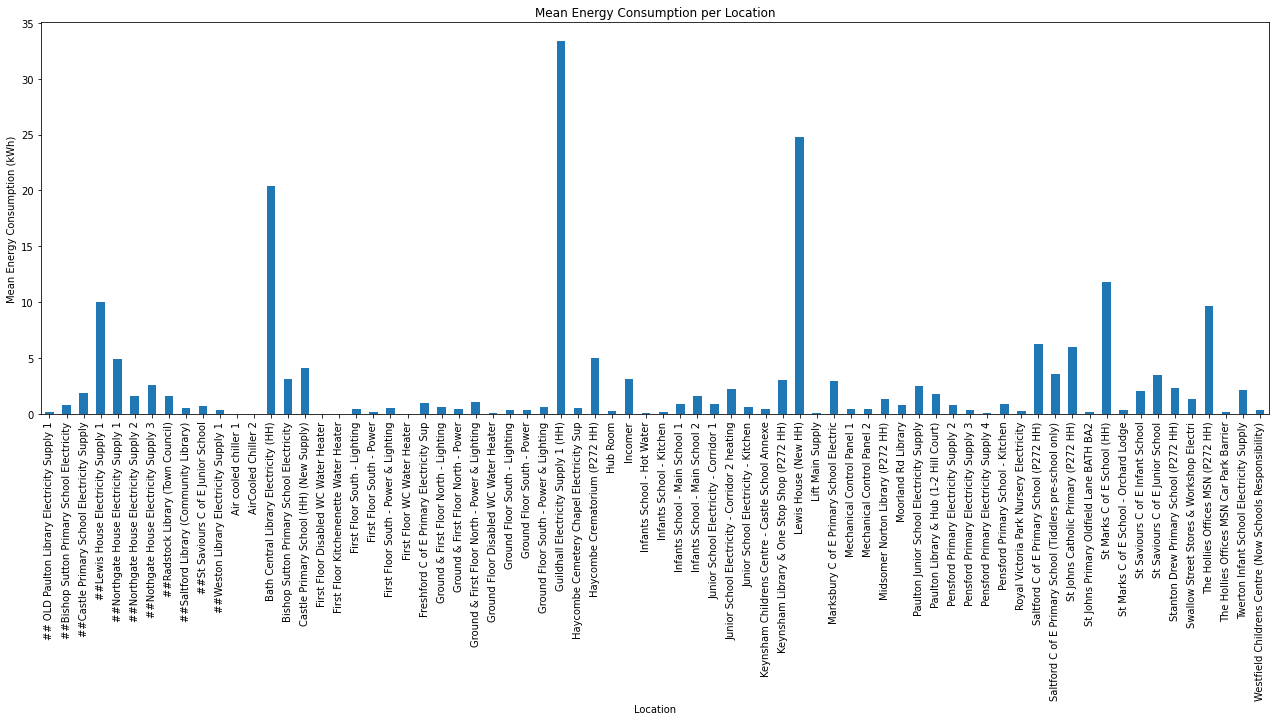

In [9]:
# extend figure to full screen
plt.figure(figsize=(22, 7.2))

# mean energy per location
df.groupby(['location']).mean()['energy'].plot(kind='bar')
plt.title('Mean Energy Consumption per Location')
plt.xlabel('Location')
plt.ylabel('Mean Energy Consumption (kWh)')
plt.show()

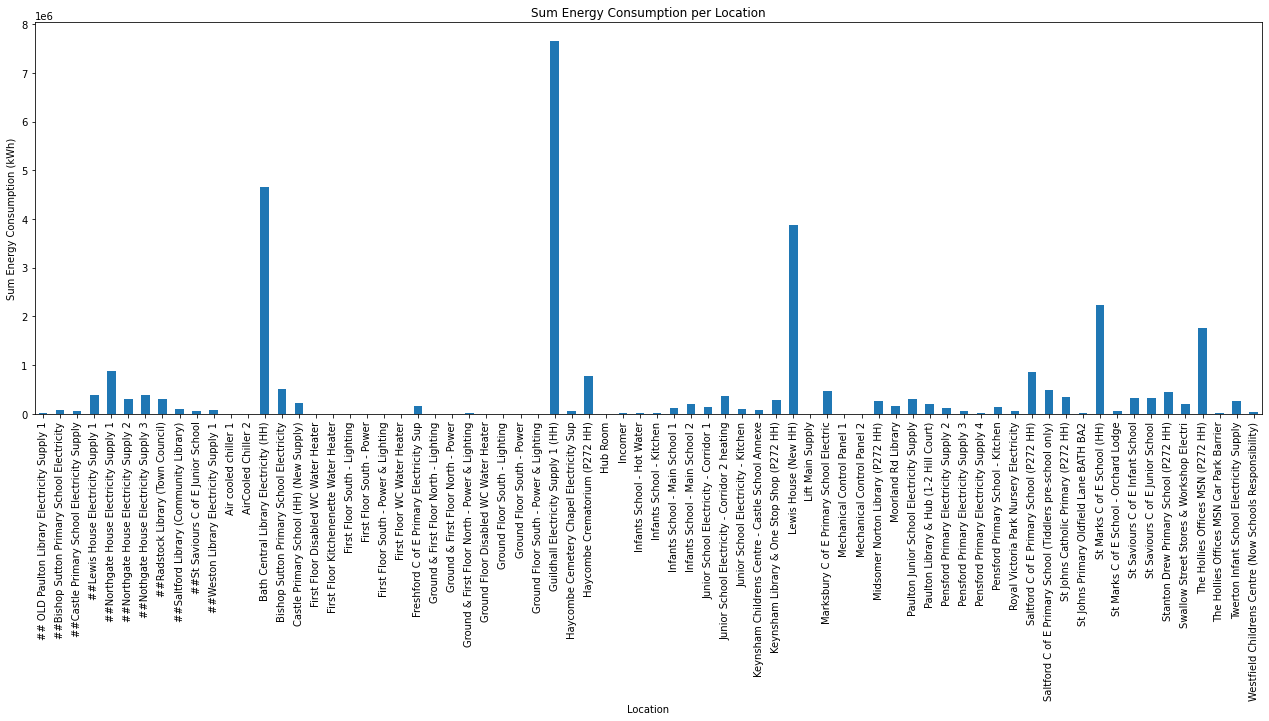

In [14]:
# extend figure to full screen
plt.figure(figsize=(22, 7.2))

# Sum energy per location
df.groupby(['location']).sum()['energy'].plot(kind='bar')
plt.title('Sum Energy Consumption per Location')
plt.xlabel('Location')
plt.ylabel('Sum Energy Consumption (kWh)')
plt.show()

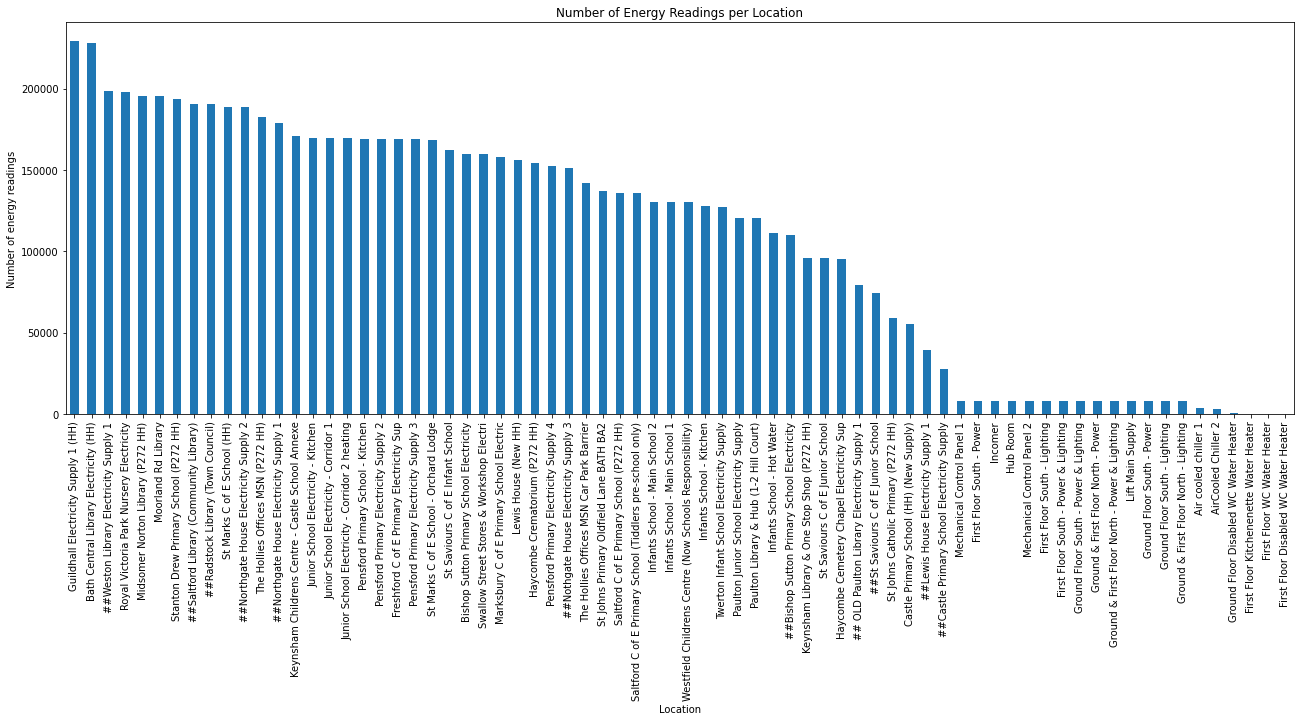

In [16]:
plt.figure(figsize=(22, 7.2))

df['location'].value_counts().plot(kind='bar')
plt.title('Number of Energy Readings per Location')
plt.xlabel('Location')
plt.ylabel('Number of energy readings')
plt.show()

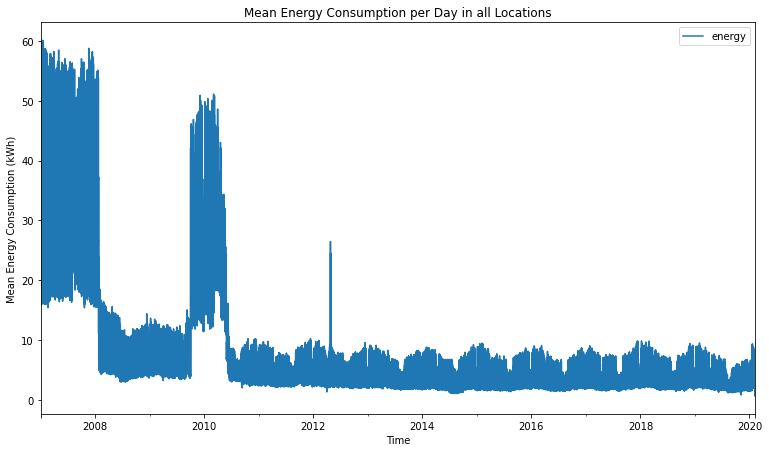

In [18]:
df.groupby(['time']).mean().plot(y='energy', kind='line')
plt.title('Mean Energy Consumption per Day in all Locations')
plt.xlabel('Time')
plt.ylabel('Mean Energy Consumption (kWh)')
plt.show()

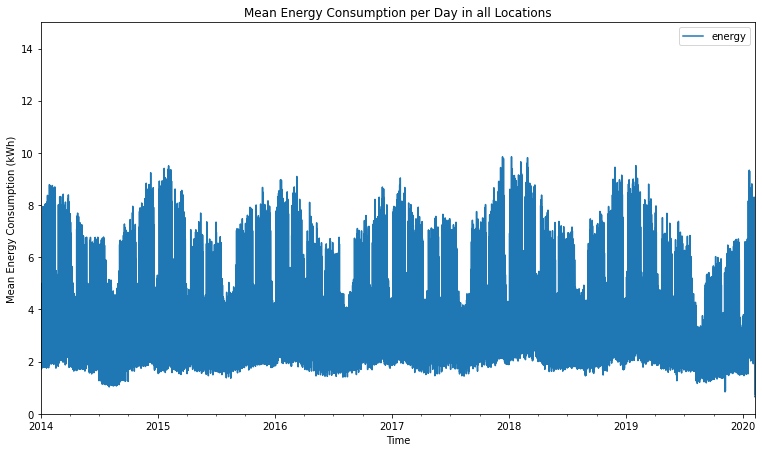

In [24]:
df.groupby(['time']).mean().plot(y='energy', kind='line')
plt.title('Mean Energy Consumption per Day in all Locations')
plt.xlabel('Time')
plt.ylabel('Mean Energy Consumption (kWh)')
plt.xlim(pd.Timestamp('2014-01-01'), plt.xlim()[1])
plt.ylim(0, 15)
plt.show()

In [12]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

df.describe()


,energy,AirTemp,RelativeHumidity,Dni
count,7759968.000,7759968.000,7759968.000,7759968.000
mean,4.016,10.374,0.822,94.575
std,8.422,5.623,0.129,214.412
min,0.000,-9.000,0.306,0.000
25%,0.219,6.400,0.745,0.000
50%,0.749,10.300,0.859,0.000
75%,3.219,14.400,0.926,15.000
max,74.700,29.700,1.000,946.000
